In [ ]:
!pip install patchify==0.2.3  #hay que reiniciar entorno después de esto
!pip install imagecodecs==2024.12.30


In [ ]:
import os
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
np.random.seed(0)

In [ ]:
# CLAHE
def clahe_equalized(imgs):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = clahe.apply(imgs)
    return imgs_equalized

patch_size = 256


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# modelos.py

from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)

    #skip connection
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])
    return respath


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock

#Simple U-NET
def unetmodel(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)

    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)

    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)

    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model


#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)

    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)

    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)

    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

#Res-UNET
def residualunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers
    dn_conv1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    dn_pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv1)

    dn_conv2 = res_conv_block(dn_pool1, kernelsize, filters[1], dropout, batchnorm)
    dn_pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv2)

    dn_conv3 = res_conv_block(dn_pool2, kernelsize, filters[2], dropout, batchnorm)
    dn_pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv3)

    dn_conv4 = res_conv_block(dn_pool3, kernelsize, filters[3], dropout, batchnorm)
    dn_pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv4)

    dn_conv5 = res_conv_block(dn_pool4, kernelsize, filters[4], dropout, batchnorm)

    # upsampling layers
    up_conv6 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_conv5)
    up_conv6 = layers.concatenate([up_conv6, dn_conv4], axis=3)
    up_conv6 = res_conv_block(up_conv6, kernelsize, filters[3], dropout, batchnorm)

    up_conv7 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv6)
    up_conv7 = layers.concatenate([up_conv7, dn_conv3], axis=3)
    up_conv7 = res_conv_block(up_conv7, kernelsize, filters[2], dropout, batchnorm)

    up_conv8 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv7)
    up_conv8 = layers.concatenate([up_conv8, dn_conv2], axis=3)
    up_conv8 = res_conv_block(up_conv8, kernelsize, filters[1], dropout, batchnorm)

    up_conv9 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv8)
    up_conv9 = layers.concatenate([up_conv9, dn_conv1], axis=3)
    up_conv9 = res_conv_block(up_conv9, kernelsize, filters[0], dropout, batchnorm)


    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv9)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

#Residual-Attention UNET (RA-UNET)
def residual_attentionunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape)

    # Downsampling layers
    dn_1 = res_conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = res_conv_block(pool1, kernelsize, filters[1], dropout, batchnorm)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = res_conv_block(pool2, kernelsize, filters[2], dropout, batchnorm)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = res_conv_block(pool3, kernelsize, filters[3], dropout, batchnorm)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = res_conv_block(pool4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = res_conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)

    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = res_conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)

    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = res_conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)

    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = res_conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)

    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

In [ ]:
# evaluation metrics

from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc

def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)
   return np.mean(IoU)


In [ ]:
from tensorflow.keras.optimizers import Adam

IMG_HEIGHT = patch_size
IMG_WIDTH = patch_size
IMG_CHANNELS = 1

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = attentionunet(input_shape) #/unetmodel/residualunet(input_shape)/attentionunet(input_shape)/residual_attentionunet(input_shape)
model.compile(optimizer = Adam(learning_rate = 1e-3), loss= IoU_loss, metrics= ['accuracy', IoU_coef])
model.load_weights('/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/vasos_unet/retina_attentionUnet_150epochs.hdf5') #loading weights



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][

 Total params: 2,341,513 (8.93 MB)

 Trainable params: 2,337,607 (8.92 MB)

 Non-trainable params: 3,906 (15.26 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Execution time:  0:00:05.481858


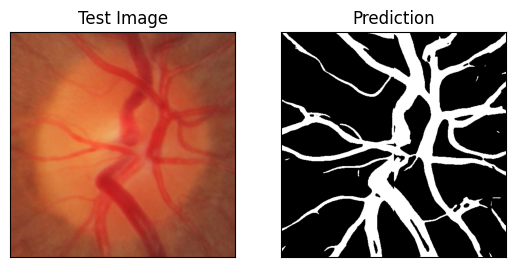

In [ ]:
#prediction on single image
from datetime import datetime
reconstructed_image = []
test_img = skimage.io.imread('/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/reescalado/r2_Im034.png') #test image

#test_img = cv2.resize(test_img, (256, 256))
#patch_size = 128

predicted_patches = []
start = datetime.now()

test = test_img[:,:,1] #selecting green channel
test = clahe_equalized(test) #applying CLAHE
SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
test = cv2.resize(test, (SIZE_X, SIZE_Y))
test = np.array(test)
patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
          single_patch = patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) / 255.
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
          predicted_patches.append(single_patch_prediction)
predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img

stop = datetime.now()
print('Execution time: ',(stop-start)) #computation time

plt.subplot(121)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.imshow(test_img)
plt.subplot(122)
plt.title('Prediction')
plt.xticks([])
plt.yticks([])
plt.imshow(reconstructed_image,cmap='gray')

plt.show()

In [ ]:
reconstructed_image.max()

1

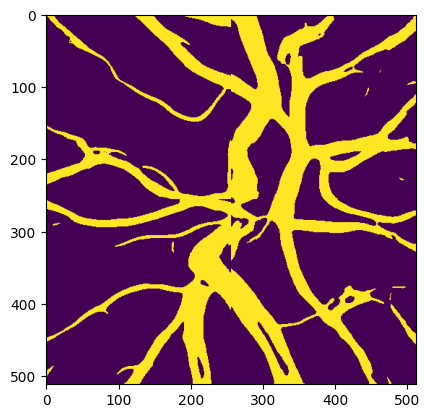

In [ ]:
ret, thresholded_image = cv2.threshold(reconstructed_image, 0, 255, cv2.THRESH_BINARY)
plt.imshow(thresholded_image)

plt.show()

In [ ]:
# Recorrer un directorio entero de imágenes

from datetime import datetime

path ='/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/Clasificación/train'
path2 = '/content/drive/MyDrive/4º Curso/Segundo cuatrimestre/TFG/Clasificación/train_segmentado'

cont=0
for nombre_archivo in os.listdir(path):
  if nombre_archivo.endswith(('.jpg', '.png', '.jpeg','.JPG')):  # Filtrar por extensiones de imagen
    ruta_imagen = os.path.join(path, nombre_archivo)
    reconstructed_image = []
    test_img = skimage.io.imread(ruta_imagen) #test image

    predicted_patches = []
    start = datetime.now()
    test = test_img[:,:,1] #selecting green channel
    test = clahe_equalized(test) #applying CLAHE
    SIZE_X = (test_img.shape[1]//patch_size)*patch_size #getting size multiple of patch size
    SIZE_Y = (test_img.shape[0]//patch_size)*patch_size #getting size multiple of patch size
    test = cv2.resize(test, (SIZE_X, SIZE_Y))
    test = np.array(test)
    patches = patchify(test, (patch_size, patch_size), step=patch_size) #create patches(patch_sizexpatch_sizex1)

    for i in range(patches.shape[0]):
          for j in range(patches.shape[1]):
              single_patch = patches[i,j,:,:]
              single_patch_norm = (single_patch.astype('float32')) / 255.
              single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
              single_patch_input = np.expand_dims(single_patch_norm, 0)
              single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) #predict on single patch
              predicted_patches.append(single_patch_prediction)
    predicted_patches = np.array(predicted_patches)
    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], patch_size,patch_size) )
    reconstructed_image = unpatchify(predicted_patches_reshaped, test.shape) #join patches to form whole img
    stop = datetime.now()
    print('Execution time: ',(stop-start)) #computation time
    imagen_8bit = (reconstructed_image * 255).astype(np.uint8)
    #plt.imshow(imagen_8bit,cmap='gray')
    #plt.show()
    cont=cont+1
    print(cont)

    ruta_completa = os.path.join(path2, nombre_archivo)
    cv2.imwrite(ruta_completa, imagen_8bit)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Execution time:  0:00:00.080416
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Execution time:  0:00:00.109369
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Execution time:  0:00:00.077342
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Execution time:  0:00:00.192709
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Execution time:  0:00:00.141044
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Execution time:  0:00:00.117019
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Execution time:  0:00:00.132086
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Execution time:  0:00:00.081330
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Execution time:  0:00:00.127972
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Execution time:  0:00:00.079764
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Execution time:  0:00:00.113555
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Execution time:  0:00:00.110196
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Execution time:  0:00:00.110114
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Execution time:  0:00: